### SETTINGS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.gray();

import skimage
from skimage.io import imread, imsave
from skimage.transform import rotate, resize, AffineTransform, warp
from skimage.filters import gaussian, threshold_otsu, threshold_local
from skimage.feature import blob_dog, corner_fast, corner_peaks, corner_harris
from skimage.color import rgb2gray

from scipy import ndimage

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display

<Figure size 640x480 with 0 Axes>

In [2]:
file = r"C:\Users\A\Pictures\icons\steel.jpg"
im = imread(file)
gray = rgb2gray(im)  # gray

### 二値化

interactive(children=(IntSlider(value=51, description='block_size', max=500, min=1, step=10), Output()), _dom_…

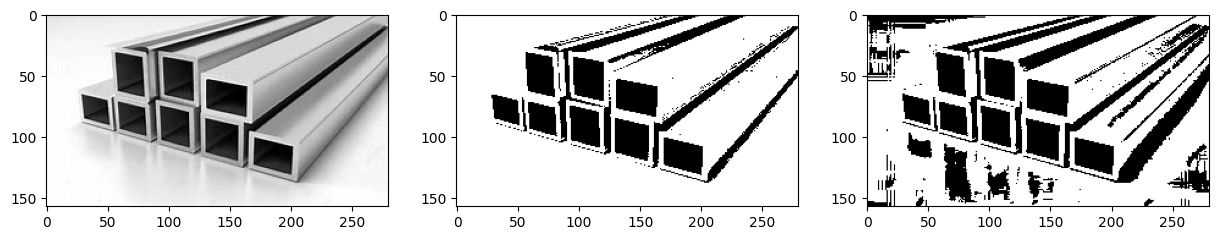

In [3]:
@interact(block_size=(1, 500, 10))
def g(block_size=51):
    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(1, 3, 1)
    plt.imshow(gray)

    # Otsu th
    ax = fig.add_subplot(1, 3, 2)
    global_th = threshold_otsu(gray)
    binary_global = gray > global_th
    plt.imshow(binary_global)

    # adaptive thresholding
    ax = fig.add_subplot(1, 3, 3)
    adaptive_th = threshold_local(gray, block_size)
    binary_adaptive = gray > adaptive_th
    plt.imshow(binary_adaptive)



### 解像度変換

#### height_slider/width_slider

In [19]:
# Create sliders for new height and width
height_slider = widgets.IntSlider(value=im.shape[0], min=1, max=9999, step=1, description='Height:')
width_slider = widgets.IntSlider(value=im.shape[1], min=1, max=9999, step=1, description='Width:')

# Define the function to save the resized image
def save_image(new_height, new_width):
    resized_image = resize(im, (new_height, new_width), anti_aliasing=True)
    output_path = file.split('.')[0] + '_output.tif'
    print(output_path)
    imsave(output_path, (resized_image * 255).astype('uint8'))  # Save as TIFF
    print(f"Image saved as: {output_path}")

# Define what happens when the button is clicked
def on_save_button_clicked(b):
    save_image(height_slider.value, width_slider.value)

# Function to resize and display the image
@interact(new_height=height_slider, new_width=width_slider)
def resize_image(new_height, new_width):
    # Resize the image
    img_resized = resize(im, (new_height, new_width))
    # Display the image
    plt.imshow(img_resized)
    plt.show()

# Create a button to save the image
save_button = widgets.Button(description="Save Image")
# Attach the button click event to the handler
save_button.on_click(on_save_button_clicked)
# Desplay the butt
display(save_button)

interactive(children=(IntSlider(value=157, description='Height:', max=9999, min=1), IntSlider(value=280, descr…

Button(description='Save Image', style=ButtonStyle())

### 幾何変換

#### Affine

In [24]:
@interact(angle=(-180, 180, 10))
def g(angle=0):
    fig = plt.figure(figsize=(15,3))
    fig.add_subplot(1, 3, 1)
    im_rot = rotate(im, angle=angle, resize=False)
    plt.title('resize=False')
    plt.imshow(im_rot)

    fig.add_subplot(1, 3, 2)
    im_rot = rotate(im, angle=angle, resize=True)
    plt.title('resize=True')
    plt.imshow(im_rot)

    fig.add_subplot(1, 3, 3)
    angle = np.deg2rad(angle)
    A = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle), np.cos(angle), 0],
                  [0, 0, 1]])
    plt.title('原点中心')
    plt.imshow(warp(im, AffineTransform(A)))

    plt.show()

interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180, step=10), Output()), _dom_cla…

### Filters

#### Sobel, Prewitt

In [20]:
kernels = {'diff': np.array([[ 0,0,0],
                             [-1,0,1],
                             [ 0,0,0]]) / 2,
           'prewitt': np.array([[-1,0,1],
                                [-1,0,1],
                                [-1,0,1]]) / 6,
           'sobel': np.array([[-1,0,1],
                              [-2,0,2],
                              [-1,0,1]]) / 8
          }

if len(im.shape) == 3:
    im = rgb2gray(im)

@interact(kernel=['diff', 'prewitt', 'sobel'], val_max=(0.1, 0.5, 0.1))
def g(kernel='diff', val_max=0.1):
    k = kernels[kernel]

    imh = ndimage.convolve(im, k)
    imv = ndimage.convolve(im, k.T)  # 転置
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 3, 1)
    plt.imshow(imh, cmap="bwr")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 2)
    plt.imshow(imv, cmap="bwr")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(np.sqrt(imv**2 + imh**2), cmap="gray")
    plt.colorbar()

    plt.show()

interactive(children=(Dropdown(description='kernel', options=('diff', 'prewitt', 'sobel'), value='diff'), Floa…

#### Hough

#### DoG

interactive(children=(IntSlider(value=50, description='max_sigma', max=300, min=10, step=10), FloatSlider(valu…

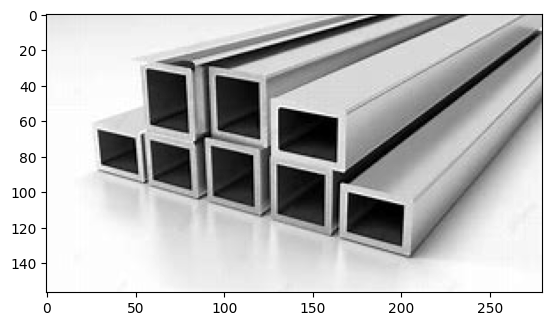

In [21]:
@interact(max_sigma=(10, 300, 10), threshold=(0.02, 1, 0.02))
def g(max_sigma=50, threshold=0.2):

    keypoints1 = blob_dog(im, max_sigma=max_sigma, threshold=threshold, overlap=1)

    fig = plt.figure()
    ax = fig.add_subplot()
    plt.imshow(im)

    for k in keypoints1:
        # print(k)
        y, x, s, _ = k
        ax.add_patch(plt.Circle((x, y), s, edgecolor='r', facecolor='none', lw=1))

    plt.title(f'# of keypoints {len(keypoints1)}')
    plt.show()

#### FAST

In [22]:
@interact(n=(1, 16, 1), threshold=(0.1, 0.6, 0.05))
def g(n=10, threshold=0.4):

    keypoints1 = corner_peaks(corner_fast(gray, n=n, threshold=threshold))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()
    plt.imshow(im)
    ax.scatter(keypoints1[:, 1], keypoints1[:, 0], color='r', marker='o', s=80, facecolors='none')

    plt.title(f'# of keypoints {len(keypoints1)}')
    plt.show()

interactive(children=(IntSlider(value=10, description='n', max=16, min=1), FloatSlider(value=0.4, description=…

#### Harris

In [23]:
@interact(k=(0, 0.6, 0.01), sigma=(0.5, 5, 0.5))
def g(k=0.15, sigma=3):

    keypoints1 = corner_peaks(corner_harris(gray, k=k, sigma=sigma))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()
    plt.imshow(im)
    ax.scatter(keypoints1[:, 1], keypoints1[:, 0], color='r', marker='o', s=80, facecolors='none')

    plt.title(f'# of keypoints {len(keypoints1)}')
    plt.show()

interactive(children=(FloatSlider(value=0.15, description='k', max=0.6, step=0.01), FloatSlider(value=3.0, des…